In [1]:
using Random
using Plots
using Distributions
using AdaptiveSurveillance

┌ Info: Precompiling AdaptiveSurveillance [69006bd4-4c56-49bd-9558-74ccc455f1d0]
└ @ Base loading.jl:1278


In [2]:
const output_path = joinpath(dirname(pathof(AdaptiveSurveillance)), "..", "results", "tmp")
const L = 2
const ν = 1 / (52 * 5) # approx 6 months until there is an outbreak
const Γd = [Geometric(ν) for l = 1:L]
const p0 = [0.01, 0.02]#0.01 * ones(L)
const β = 4e-6 * 536 * 7
const p = repeat(prevalance_sequence(p0[1], β), 1, L)
const n = 200

200

In [3]:
α = 1000 # the higher, the less false positives

1000

In [30]:
T = length(p[:, 1])
p_logistic(t) = max(p0[1], 1 / (1 + exp(β * 52 + -β * t + log((1 / p0[1] - 1))))); # analytical solution
pred_log = zeros(T)
for t = 1:T
    pred_log[t] = p_logistic(t)
end

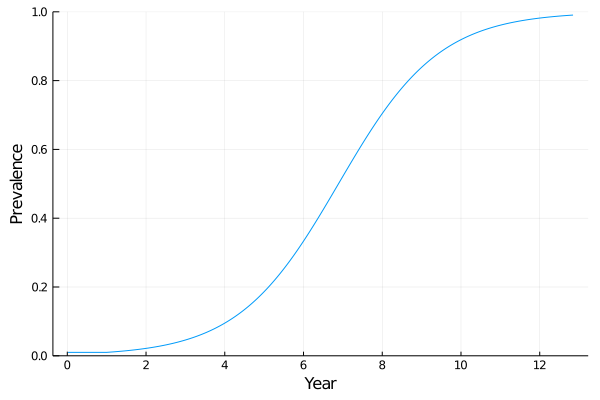

In [31]:
plot((1:T) ./ 52, pred_log, ylim=(0, 1), legend=false, xlabel = "Year", ylabel = "Prevalence")

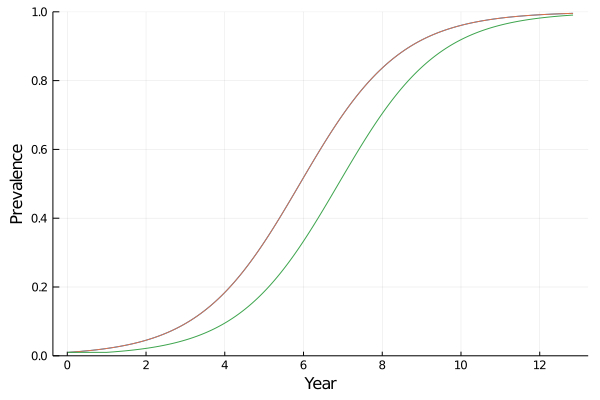

In [7]:
# Prevalance Sequence
plot((1:T)./52, hcat(p, pred_log), ylim=(0, 1), legend=false, xlabel = "Year", ylabel = "Prevalence")

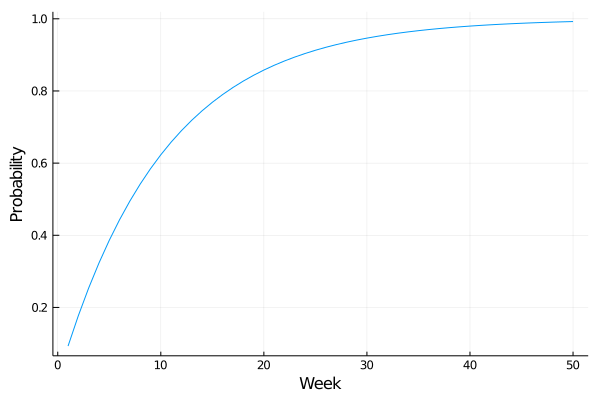

In [93]:
# Probability of any change point over time
Γd_all = Geometric(1 - prod(1 .- succprob.(Γd)))
plot(1:50, cdf.(Γd_all, 0:(49)), legend = false, ylabel = "Probability", xlabel = "Week")

In [4]:
# Debug
Γ = [typemax(Int64), 0]
beta_parameters = ones(L, 2)
fraction_forget = 0.5
t, la, false_alarm, delay, test_data, locations_visited, ntimes_visisted, z, w = replication(L, Γ, p0, p, n, 
    astat_isotonic, α, tpolicy_evsi, tstate_evsi(Γd, beta_parameters, fraction_forget),
    rng1 = MersenneTwister(1), rng2 = MersenneTwister(2), maxiters = 1000);

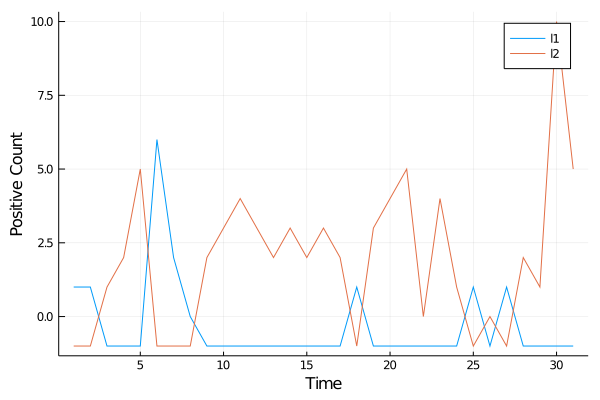

In [5]:
plot(1:(t-1), test_data[1:(t-1), :], xlabel = "Time", ylabel = "Positive Count", labels = ["l1" "l2" "l3"])

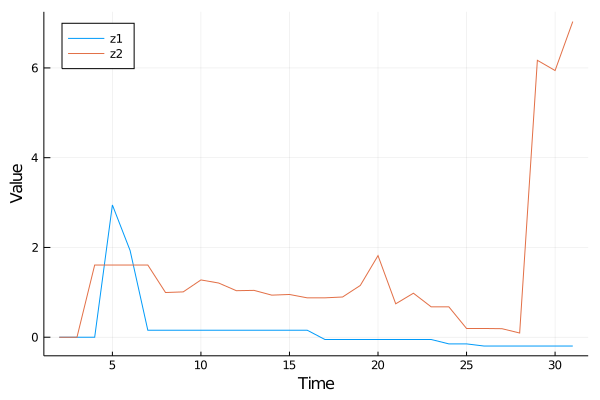

In [6]:
plot(2:(t-1), z[3:t, :], xlabel = "Time", ylabel = "Value", 
    label = permutedims(["z$l" for l = 1:L]), legend=:topleft)

In [37]:
# Alarm time distribution
atd_T = 200
atd_0 = alarm_time_distribution(Int(1e4), L, Γd, zeros(Int64, L), p0, p, n, astat_isotonic, α, 
    tpolicy_constant, tstate_const(2), maxiters=atd_T);
atd_0 = cumsum(atd_0) ./ sum(atd_0);

In [38]:
atd_1 = alarm_time_distribution(Int(1e4), L, Γd, ones(Int64, L) * typemax(Int64), p0, p, n, astat_isotonic, α, 
    tpolicy_constant, tstate_const(2), maxiters=atd_T);
atd_1 = cumsum(atd_1) ./ sum(atd_1);

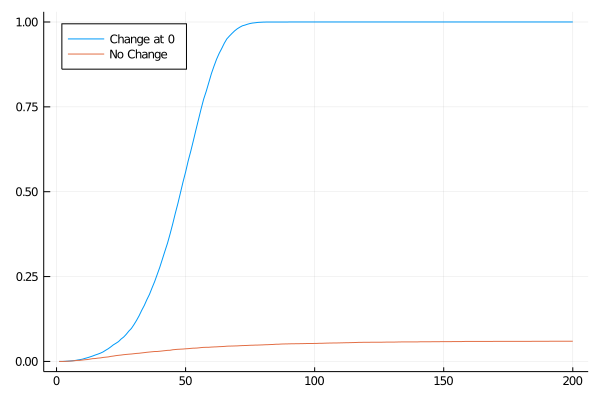

In [39]:
plot(1:atd_T, hcat(atd_0[1:atd_T], atd_1[1:atd_T]), label = ["Change at 0" "No Change"], legend=:topleft)

In [14]:
# Probability of successful detection
T_end = 21
sp2s = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_constant, tstate_const(1));
sp3s = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_constant, tstate_const(1));

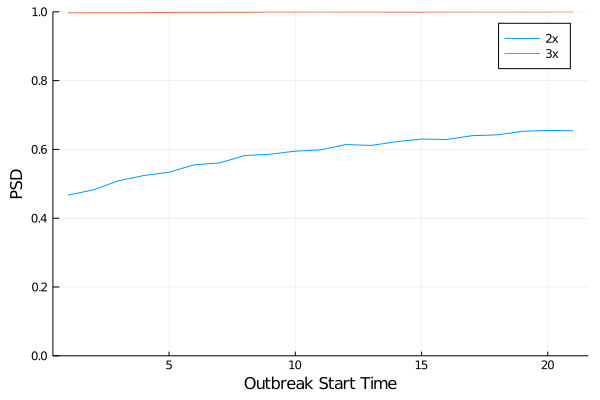

In [15]:
plot(1:T_end, hcat(sp2s, sp3s), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [17]:
sp2r = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_random, nothing);
sp3r = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_random, nothing);

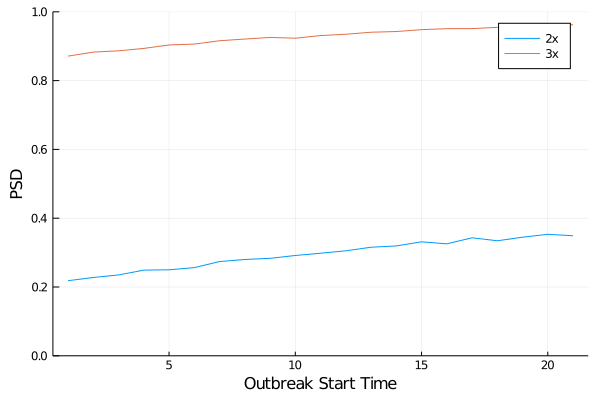

In [18]:
plot(1:T_end, hcat(sp2r, sp3r), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [8]:
# thompson sampling
sp2ts = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_thompson, tstate_thompson(ones(L, 2)));
sp3ts = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_thompson, tstate_thompson(ones(L, 2)));

LoadError: UndefVarError: T_end not defined

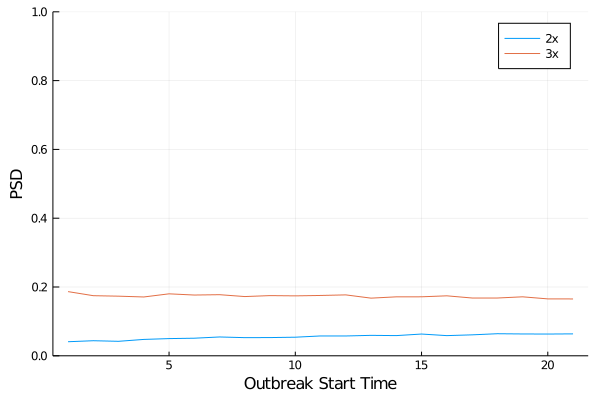

In [20]:
plot(1:T_end, hcat(sp2ts, sp3ts), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [16]:
beta_parameters = ones(L, 2)
fraction_forget = 0.5

@time sp2ts = probability_successfull_detection_l(Int(1e4), 2, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_evsi, tstate_evsi(Γd, beta_parameters, fraction_forget));
#sp3ts = probability_successfull_detection_l(Int(1e4), 2, 75, 1, L, p0, p, n, astat_isotonic, α,
#    tpolicy_evsi, tstate_evsi(Γd, beta_parameters, fraction_forget));


[0.9517020493962429, 0.3764643428082435]
[0.48513888211750095, 0.6299415165480806]
[0.8387341515989448, 0.511219748442824]
[0.9034869389192236, 0.7460597060661682]
[0.7839366590516855, 0.669976972053791]
[0.30386473311563067, 0.6946063973210721]
[0.3017134874019608, 0.33608994436577483]
[0.5288431509311657, 0.546405799534101]
[0.15161678726825362, 0.1392996085928326]
[0.7957337923260805, 0.7106355321154656]
[0.19975699710611164, 0.7188426935326075]
[0.8621953489097478, 0.4383668681701484]
[0.5520622241826444, 0.6676519768137614]
[0.5141999852822491, 0.4001902635905074]
[0.09920779668360484, 0.5898830620538456]
[0.25693020886381396, 0.7357773049655074]
[0.47457407003857477, 0.5696206732929763]
[0.25683248900161115, 0.36054032788404505]
[0.16995484545686446, 0.30422353312103206]
[0.41993004463884104, 0.4455645345102355]
[0.4714688292114709, 0.5596035107086886]
[0.5213991423243428, 0.6232991536886223]
[0.6284415758499168, 0.4222571502281511]
[0.4572514869427741, 0.3624804055889904]
[0.14

LoadError: TaskFailedException:
InterruptException:
Stacktrace:
 [1] tpolicy_evsi(::Int64, ::Int64, ::Function, ::Int64, ::tstate_evsi, ::MersenneTwister, ::Array{Float64,2}, ::Array{Int64,1}, ::Array{Int64,2}, ::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}, ::Int64) at /Users/mfairley/Projects/AdaptiveSurveillance/src/semiparametric.jl:158
 [2] replication(::Int64, ::Array{Int64,1}, ::Array{Float64,1}, ::Array{Float64,2}, ::Int64, ::typeof(astat_isotonic), ::Int64, ::typeof(tpolicy_evsi), ::tstate_evsi; maxiters::Int64, warn::Bool, rng1::MersenneTwister, rng2::MersenneTwister) at /Users/mfairley/Projects/AdaptiveSurveillance/src/semiparametric.jl:28
 [3] macro expansion at /Users/mfairley/Projects/AdaptiveSurveillance/src/semiparametric.jl:177 [inlined]
 [4] (::AdaptiveSurveillance.var"#63#threadsfor_fun#19"{Int64,Int64,Array{Int64,1},Array{Float64,1},Array{Float64,2},Int64,typeof(astat_isotonic),Int64,typeof(tpolicy_evsi),tstate_evsi,Array{Float64,1},Array{MersenneTwister,1},Array{MersenneTwister,1},UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:81
 [5] (::AdaptiveSurveillance.var"#63#threadsfor_fun#19"{Int64,Int64,Array{Int64,1},Array{Float64,1},Array{Float64,2},Int64,typeof(astat_isotonic),Int64,typeof(tpolicy_evsi),tstate_evsi,Array{Float64,1},Array{MersenneTwister,1},Array{MersenneTwister,1},UnitRange{Int64}})() at ./threadingconstructs.jl:48

[0.395266054539803, 0.1254844306599662]
[0.7979121126535196, 0.46814561192864423]
[0.940148422678109, 0.43490056222864754]
[0.3618836625877596, 0.7375448303335804]
[0.5727179404285105, 0.4904753240478816]
[0.9850427549429844, 0.14432422361269287]
[0.6664928231272407, 0.5872033937948692]
[0.6830837351043734, 0.5908852812667595]
[0.31026395252522854, 0.7582602177147293]
[0.09546078939674475, 0.5171345533339533]
[0.3226844442806867, 0.5856675656176235]
[0.40183161862654165, 0.6686990421854027]
[0.9127373889034234, 0.6050109486367751]
[0.38645905851979234, 0.45209619537862766]
[0.719049824770542, 0.7435126305611863]
[0.5478236124497892, 0.3755033576702221]
[0.5157072293547559, 0.2711114927652104]
[0.2834356300771025, 0.513810625439259]
[0.6784794681399327, 0.20416295021247519]
[0.24430247507422456, 0.6990823897031804]
[0.5984061133643772, 0.568880973503254]
[0.6482505014338621, 0.6332848856190294]
[0.2012482599748849, 0.5325018128886286]
[0.6998815841866671, 0.54841934224569]
[0.7235734393

[0.44779821095757144, 0.0739161684560274]
[0.07136712632370705, 0.7596164929437524]
[0.5873487329712479, 0.39233613357806896]
[0.5363267546983718, 0.43307903841475326]
[0.7873038770515052, 0.7818445406607014]
[0.6930170117726214, 0.4511397189133877]
[0.43441435666631134, 0.6836938903515231]
[0.8262060131885128, 0.7950488543052201]
[0.2781735234444875, 0.35871676987170936]
[0.39344282136890285, 0.40285869958549214]
[0.3716176982504809, 0.6633180983942907]
[0.5985514453104288, 0.4688804238992953]
[0.6026211204024581, 0.3585058534280058]
[0.6353833316667896, 0.4441838461182455]
[0.2431271719061297, 0.49066680504739074]
[0.3909653972138312, 0.652074096872529]
[0.6190739784910109, 0.6300146551553433]
[0.4522463125145222, 0.3460005614917924]
[0.5069893355213125, 0.32703154179775734]
[0.7586467276339088, 0.42280041978590643]
[0.5652129252750178, 0.5575786663074112]
[0.24475134409342875, 0.7938441679128904]
[0.3554983913109865, 0.6055189112273386]
[0.7189995755703646, 0.5744376647317531]
[0.31

[0.8114944102821875, 0.4174263474747721]
[0.5958479879394889, 0.41230611144876694]
[0.18020900157736672, 0.5668825400825939]
[0.3935395065171349, 0.6899120023481774]
[0.6910144019407551, 0.2421578241315134]
[0.4986257199882842, 0.7430404057484982]
[0.16382663173636314, 0.693938985416131]
[0.2784158090817499, 0.2438706854022197]
[0.5707344219117911, 0.4485363050402455]
[0.5891922776536722, 0.7168747869454147]
[0.5434576893197312, 0.5489467740095291]
[0.4602011253916045, 0.3926631990139254]
[0.6690794079765062, 0.7825541998295934]
[0.2946448827553195, 0.5742014125446065]
[0.5241921681990006, 0.326352088185131]
[0.8196686283736003, 0.6538357836317967]
[0.4672687326511376, 0.392317696252229]
[0.4807148113025259, 0.5505902721432657]
[0.3925173023100143, 0.44100180120670157]
[0.40174615930764895, 0.4118094041937894]
[0.3619888269558867, 0.5205736444408608]
[0.44449475261274785, 0.5437776983661973]
[0.3982053985056486, 0.3689068334871897]
[0.7212028077187319, 0.47151043189615405]
[0.445931081

[0.6622424302303219, 0.8365550056974442]
[0.2350869309998454, 0.4359671727910158]
[0.6881603609602811, 0.6893637081086945]
[0.41142113337657354, 0.395609215262834]
[0.14214526967138286, 0.5418432154379753]
[0.24693948246808672, 0.6210909748371118]
[0.3795718287435467, 0.7263390004527981]
[0.5225861291951052, 0.531679008032955]
[0.6547797516053996, 0.5291045092042073]
[0.6898752576764353, 0.4724313215743151]
[0.29387773935189393, 0.4792879950782935]
[0.5572552150377497, 0.6177938671171109]
[0.4133738566999791, 0.475317295276537]
[0.4689833110141511, 0.6295461882535851]
[0.4066896263710323, 0.5777317670742955]
[0.9124360811928313, 0.6275936907002871]
[0.5675797908970984, 0.5505426559198493]
[0.34570382212760725, 0.4111349438505214]
[0.31918392650082644, 0.31524339940165413]
[0.5425160158078036, 0.7086191669556767]
[0.29723061863298056, 0.5519687590382287]
[0.44684205585339726, 0.6031114530307843]
[0.40729713433895465, 0.23796385361624345]
[0.9636536749035218, 0.6405388079032391]
[0.79788

[0.33658752120750407, 0.35543542837563985]
[0.9237189970634234, 0.21337527900793507]
[0.583550993668116, 0.3026198520881791]
[0.377222747314335, 0.42305694605021743]
[0.6420285719161416, 0.7959348990097558]
[0.3860628192321246, 0.5885423925832721]
[0.4104759633104244, 0.7339577926472926]
[0.3215701598767323, 0.3946481446766849]
[0.9705087466332901, 0.6394639296172356]
[0.7815944604782736, 0.6818670930198074]
[0.5460176313258644, 0.7172481998111843]
[0.021319542886055292, 0.4826153581785454]
[0.5412212852537042, 0.6889207332129463]
[0.5567470381626902, 0.7808904824521028]
[0.560736324222808, 0.10213237729124468]
[0.5125891998359984, 0.3996505580771246]
[0.6765633279415109, 0.9965640742545161]
[0.6422472875861999, 0.6670179624895551]
[0.49914052360758954, 0.677842340728542]
[0.7304044285349957, 0.3666465094864572]
[0.5239685405560912, 0.7269028396637254]
[0.7362574325332095, 0.7520118141763737]
[0.4689729070607937, 0.33036808980249743]
[0.852069125361068, 0.5252658795287718]
[0.273672979

[0.3208412967700951, 0.5694386100349762]
[0.5926625080031971, 0.41766681475546874]
[0.43868474903482446, 0.9992806648928927]
[0.6704132045537713, 0.5292398325776353]
[0.693989533156711, 0.3996990720108837]
[0.37776759108821173, 0.14743294532272855]
[0.2707517420710228, 0.2891499654025726]
[0.7669339822706969, 0.4930629739963664]
[0.4824589398463948, 0.5707507399138941]
[0.4738495810847004, 0.20170073855732473]
[0.6001764032152084, 0.5208912456095215]
[0.6061882894458771, 0.5774830453104266]
[0.2623415594460379, 0.6409196379891835]
[0.15702499862298405, 0.36357995053901565]
[0.13930421101598764, 0.5301399567646432]
[0.4038151469660236, 0.6781790203019115]
[0.5098092742978207, 0.748064385940075]
[0.5144530017259106, 0.5836979559588319]
[0.28791656626290807, 0.4545499621034789]
[0.47647303610283787, 0.5958490720464287]
[0.8557321934228747, 0.10934327588265189]
[0.4662283888523535, 0.3764644266147409]
[0.901361589426406, 0.40806608372084485]
[0.5081080000289082, 0.8308579823148474]
[0.4478

[0.6896089966184428, 0.3034910883309078]
[0.44264690637398485, 0.6470801839183934]
[0.33576071458439855, 0.6271620356428698]
[0.47830396339468745, 0.6436983554711273]
[0.556094418678885, 0.48419582209561735]
[0.5049516557669024, 0.268140544667025]
[0.3893810996178467, 0.4828379708292782]
[0.3919031289049796, 0.6033346972896169]
[0.3265652751599662, 0.26717637117381193]
[0.09262033209385284, 0.33531407389109974]
[0.11476744127670331, 0.7203719896798638]
[0.49508188448033497, 0.3245166438494369]
[0.42562954137586295, 0.7015483250294575]
[0.31622041819712804, 0.5092646178875305]
[0.5440356662080377, 0.21357807081691493]
[0.48456551575098955, 0.4608567632461437]
[0.533938268423461, 0.6681313773421577]
[0.390012634398761, 0.19081097354094467]
[0.3478065548261218, 0.6627136582155395]
[0.6481981376697373, 0.6164358281237734]
[0.6038503017328339, 0.5835561492778887]
[0.6329949654699829, 0.7995371799787151]
[0.6577346024696964, 0.8590036662441557]
[0.4074562622110358, 0.40783003950609326]
[0.87

[0.3507077397145577, 0.2994433242767594]
[0.751442406815013, 0.30510133928851585]
[0.24840325380802258, 0.6552822571316425]
[0.4242341402691039, 0.8902952398632376]
[0.2621360847142645, 0.5775930084782616]
[0.44517283616558384, 0.9159090722218618]
[0.47635023249778885, 0.3727711607744694]
[0.06430601430359593, 0.5281302536278838]
[0.6037075364315994, 0.4745252412825346]
[0.382784675861418, 0.7327441280019319]
[0.3004383388666145, 0.5756868149944121]
[0.5980375778231678, 0.5828154093309893]
[0.5767158896353787, 0.3282168959868253]
[0.5084493305983104, 0.5149188832715936]
[0.5165792171371356, 0.3808252678985482]
[0.7680714028596756, 0.4478243831660116]
[0.3818436770787084, 0.6562651977218866]
[0.32697577503818276, 0.3577654846321009]
[0.5653687945533304, 0.2514434442403787]
[0.36033256487182824, 0.41816681667917976]
[0.9835360387136454, 0.5408642380666501]
[0.2202922500273861, 0.45916917783037453]
[0.6332057971267786, 0.40066763201346317]
[0.7329118679362616, 0.4489981059388564]
[0.32427

[0.5635188984560576, 0.8262389641586585]
[0.4258759500075505, 0.6016242751882959]
[0.577683017817086, 0.4826686447987092]
[0.3238814894865508, 0.6647592718594697]
[0.15068655090324523, 0.3934507118198461]
[0.37874160602960216, 0.7402772008912141]
[0.4270201275433199, 0.21875159718824755]
[0.6893909651239619, 0.3421988040349509]
[0.6792531160110972, 0.5782621864826495]
[0.48545715147930135, 0.4932739365032597]
[0.5728259129357832, 0.38634556436783035]
[0.45396062902000056, 0.5978735906052381]
[0.2316665455703168, 0.6128730175799391]
[0.5690388960630275, 0.36565292691136675]
[0.5357283357264723, 0.6458892377290844]
[0.20442795759612714, 0.3937289675883689]
[0.816847749769196, 0.31268126688338393]
[0.6186879405777547, 0.4663593905396537]
[0.18102511045460315, 0.2370866240469286]
[0.6054089924554784, 0.19912508764846804]
[0.27537437011874755, 0.4040969000037662]
[0.3367289328563911, 0.5932363584517306]
[0.2778628843382741, 0.4792494667966148]
[0.5781927908932704, 0.8171376732264177]
[0.480

[0.8974225440370677, 0.07796308397681068]
[0.5369220044080767, 0.6346703968010627]
[0.93596709537987, 0.5815853134893724]
[0.2049290439652003, 0.47987792342059]
[0.6187840304369694, 0.9152448952043915]
[0.8722372125039995, 0.393536944204368]
[0.35475339493777325, 0.48661314875575834]
[0.20869405772067928, 0.5615511457500525]
[0.7659124222401323, 0.629546241000123]
[0.6123996620970779, 0.5846964371390312]
[0.6139583074218715, 0.3378057775841097]
[0.5519799292197173, 0.7912457858702933]
[0.245026510477615, 0.7289741120444617]
[0.5823189530690265, 0.4413655381565421]
[0.23981465997225537, 0.9471246796446079]
[0.5206228266487584, 0.6373786882562983]
[0.7731773634734005, 0.5843339171711126]
[0.201897087229702, 0.6619367771964507]
[0.4665882726766733, 0.4658855631844776]
[0.5306795189012307, 0.2478837809010187]
[0.3455013609174042, 0.2122383565784405]
[0.5736626225159729, 0.7572710473943526]
[0.27531798228263127, 0.5604168671004809]
[0.2558265150334763, 0.3037046279753344]
[0.990784662463361

[0.3428016220654987, 0.45025942482485515]
[0.25919784842586, 0.25922180442797677]
[0.5536446300579221, 0.24810850400969947]
[0.5703456779395354, 0.6646112849510069]
[0.35429369749574136, 0.5365013237305436]
[0.35246935353918507, 0.2940405566214314]
[0.6456327832989197, 0.7461102786598103]
[0.19029530386245827, 0.5996199517503646]
[0.25127910349084615, 0.5471981816107194]
[0.5967688834041297, 0.5376305539967944]
[0.18110952558520144, 0.2205508391701154]
[0.4677906003987031, 0.38072007497194676]
[0.5769201644699244, 0.3554849058004352]
[0.4127899259641821, 0.3378612178706267]
[0.6430706293379098, 0.48093913370937197]
[0.687340224726162, 0.5757317255326293]
[0.2286135078711921, 0.4260349531612721]
[0.9213980596389618, 0.2423170209390501]
[0.19749798972128327, 0.3296184677397823]
[0.46489641525401054, 0.41990024433006184]
[0.1267372331531838, 0.411297359890484]
[0.5742381629081027, 0.5700282975294519]
[0.6046207131784255, 0.31579069826566847]
[0.07688984996536226, 0.47738234773219346]
[0.2

[0.12160574067511229, 0.5097748944000868]
[0.7821387242275931, 0.5014320303029152]
[0.041884021206986095, 0.2851526628445771]
[0.6564261698679437, 0.4869872595232216]
[0.5826468414542161, 0.08040577424724615]
[0.6993097386579269, 0.5328005882901523]
[0.62645734300892, 0.5729254622914276]
[0.4445692512300519, 0.7861353189586324]
[0.5386344794212768, 0.6476220459952459]
[0.7434988017312238, 0.5670516165661746]
[0.6019395198163746, 0.6916453337661076]
[0.7207541437243162, 0.2167825643072115]
[0.2582037315202498, 0.732402228140531]
[0.7543992035252035, 0.5866734223527643]
[0.5989209570561291, 0.33134879664299993]
[0.2451589150098009, 0.663567095517046]
[0.4631386399766563, 0.44585848775232884]
[0.542195389991142, 0.29682102658328796]
[0.7257026322034966, 0.7196121588741572]
[0.903818201688533, 0.5534219951887185]
[0.6035534044227188, 0.3255841490242487]
[0.14236675903522444, 0.6471449717154965]
[0.705005455756908, 0.4546060003283886]
[0.7818261464430242, 0.24222634698720708]
[0.69003100768

[0.764941413768129, 0.6255403861216665]
[0.4437559903907115, 0.49888571683772476]
[0.21300881966520285, 0.44781222506934504]
[0.35888759020215033, 0.568575536129517]
[0.6072780760877445, 0.39615596921256635]
[0.4670258406062509, 0.3427434069649822]
[0.7998325964939048, 0.6870264367594875]
[0.6185827570895818, 0.5767143247212805]
[0.3301475355940644, 0.2661078508527962]
[0.5193206518982237, 0.7032250355892048]
[0.3119116457536923, 0.37163667728895394]
[0.5936890467872143, 0.8154796997886992]
[0.5333075592194992, 0.42436793609980383]
[0.30012946138079216, 0.6346892905546139]
[0.5897940685847783, 0.2443299305855462]
[0.584491257504098, 0.4951190218846861]
[0.7689976633434477, 0.4787274545374195]
[0.6596674228380855, 0.2782735097638389]
[0.6066966902358312, 0.7829409196043937]
[0.33845413409562863, 0.33024428328029765]
[0.3814999741137149, 0.6071405523678108]
[0.3548371829401936, 0.7033242814188976]
[0.12530345462160922, 0.4876577183482425]
[0.4606286184287792, 0.7923339517193267]
[0.24535

[0.5799348298556478, 0.4982548522382639]
[0.6549705817069336, 0.2926241315885959]
[0.31795552801028365, 0.8259474200145313]
[0.7206135130208496, 0.3097768126719274]
[0.3951222208296598, 0.5561667361939724]
[0.5852345386963177, 0.058032623585044935]
[0.284816461818698, 0.6635608092396178]
[0.32420325557550655, 0.45646311610461504]
[0.4543669893276949, 0.4725076688372576]
[0.7693342671327049, 0.6584005011298082]
[0.05003277175824598, 0.32499407094387717]
[0.546717994806881, 0.5938311459343223]
[0.38903691305800275, 0.5900942318212264]
[0.3951568275280116, 0.191951610065471]
[0.5167537370745585, 0.39059475454698256]
[0.8146617306857238, 0.7775127382515649]
[0.3846236803258618, 0.7671815832238634]
[0.2895595864283032, 0.4063337860901842]
[0.417452408926371, 0.6521971489775957]
[0.8886367976154255, 0.4339398529165938]
[0.36471813565558625, 0.5876722987521666]
[0.738788570444638, 0.686836035991133]
[0.5655340378801575, 0.7700474663363397]
[0.33909209355086195, 0.8603698170749154]
[0.32795507

[0.24801774247407926, 0.4226408039639185]
[0.18425240590244474, 0.388113741551494]
[0.6278976671169881, 0.4763303690614956]
[0.5594407702643228, 0.22986807445525664]
[0.6564130066270072, 0.48334263269428945]
[0.6886545088549266, 0.17031858378793396]
[0.6435784590174876, 0.3015119323330337]
[0.8389230952105796, 0.2582365395304963]
[0.5455156860155688, 0.5295532439310713]
[0.5303642405089739, 0.4796549275761418]
[0.4422303521290753, 0.5940056235283847]
[0.6130188424613029, 0.5941454058176527]
[0.33613411880154337, 0.592143013010672]
[0.22000431085247324, 0.7974652576577033]
[0.409536607182959, 0.4135973570829757]
[0.31941115159978656, 0.5915321775598126]
[0.6938087971977112, 0.7083751185104509]
[0.28671506842555694, 0.20614587493179615]
[0.50081883272766, 0.44037659912680194]
[0.57034228336108, 0.5456612937198307]
[0.6289746424666617, 0.6766134646219004]
[0.3867317242665568, 0.5095607178114043]
[0.5507067402625321, 0.581663981191051]
[0.783956429170141, 0.3873074387654833]
[0.34769812114

[0.7030444094026136, 0.5920019257744183]
[0.3958640743215537, 0.5037625133871672]
[0.6920752324556904, 0.46480859617880815]
[0.16138758264131525, 0.2506518705941937]
[0.6217398878773258, 0.7728976085044144]
[0.5436686693450915, 0.6222661889867276]
[0.5472071257480655, 0.01649804612805851]
[0.6553273953373363, 0.5493769432339454]
[0.5744229599918067, 0.2559997743705404]
[0.25514855897309824, 0.5831927412868589]
[0.7972491383843573, 0.19795220018058637]
[0.3997515953085856, 0.6742499514796287]
[0.35956410698596797, 0.4247983206180834]
[0.45303572396473885, 0.43894314504410464]
[0.21844004078252616, 0.6028876389579548]
[0.4820258992937085, 0.611124999718012]
[0.7163939748962912, 0.4747726604069013]
[0.7169009124401028, 0.24209223411187825]
[0.5608305114823076, 0.2778292590916591]
[0.4115327496396136, 0.7597811941439614]
[0.7487227099124784, 0.8170494535275713]
[0.709627031493754, 0.41699848953546775]
[0.36576880231320674, 0.2953672002921835]
[0.5120118145240168, 0.23678711909086508]
[0.27

[0.5198618548972915, 0.47857033687054923]
[0.34335188689167623, 0.34955365212703954]
[0.3192179831106008, 0.6778983315309567]
[0.37428799503162474, 0.43798318494224453]
[0.21763500706087457, 0.6598954794371706]
[0.45633183322251003, 0.4733786141744474]
[0.5122147676271206, 0.4030097785085061]
[0.4376592730951956, 0.6485949553840729]
[0.28068191641977713, 0.3492734484472214]
[0.5710661639488116, 0.46169700614304326]
[0.8951429256809101, 0.611752056313706]
[0.44372784277355243, 0.864087578693968]
[0.8154297401407228, 0.4586373228738463]
[0.8334058374169098, 0.7155759860018654]
[0.7815447667052763, 0.359920411263933]
[0.03475008150490498, 0.3341580354889804]
[0.3763120909368892, 0.5168228855165445]
[0.2502506361576876, 0.685677733394]
[0.431447292082935, 0.22355191575424735]
[0.5820014069467072, 0.6933484710419816]
[0.7266679847995393, 0.49423547389033484]
[0.5444590397176096, 0.5899158352738942]
[0.5697943302126726, 0.34388006756865985]
[0.7411803123548539, 0.3273558905190412]
[0.5874193

[0.5505062885025326, 0.7355281682028778]
[0.6246102630816479, 0.766622928032451]
[0.24365858074613472, 0.8060461446384701]
[0.6373265255919388, 0.6978987322786852]
[0.3651829242351502, 0.6037993215318712]
[0.3542372165968526, 0.5682755239322568]
[0.23921599211165093, 0.563620701981233]
[0.6748797259450239, 0.2830544962285042]
[0.1274858145815169, 0.3625344018263438]
[0.3300419789221155, 0.7105876806079253]
[0.4631840803131725, 0.3795875560329127]
[0.7900777382156721, 0.7213240900128584]
[0.3664264128861272, 0.42159412051773226]
[0.4114860819608324, 0.604561539606403]
[0.3405234434244677, 0.8061833480826341]
[0.17939220696609134, 0.6280183596673604]
[0.39124791337011056, 0.7228470242870882]
[0.7471464253068938, 0.5996809918908869]
[0.642147320853547, 0.3695503154942773]
[0.6026956393098283, 0.5709645275292881]
[0.4269275164472548, 0.35911134200684514]
[0.28592229678404163, 0.4832718718622257]
[0.5678465661348838, 0.29295465885008165]
[0.3457897251527799, 0.3831458374806692]
[0.544986723

[0.30850198977926646, 0.6426338196632334]
[0.4413622853659275, 0.3066704981701499]
[0.695079423074512, 0.8363613686654298]
[0.5077123458417926, 0.4451572501110931]
[0.46948220344796726, 0.1624369787915478]
[0.46567835535585367, 0.1718646783819907]
[0.5864122791771268, 0.8217877802450745]
[0.7275349573636661, 0.18784454133403045]
[0.3694068852735587, 0.7064920578771697]
[0.22086487112858294, 0.42672381155108524]
[0.5878952815036699, 0.5933729224339133]
[0.993937003605385, 0.20455105633554604]
[0.3240220036456029, 0.655775281450999]
[0.32312626180256965, 0.3216384577816825]
[0.834353091929563, 0.3342435806487786]
[0.6021865763661384, 0.603753947129774]
[0.3779366113953127, 0.38473509288988345]
[0.6018091490475104, 0.3672560300471517]
[0.30389823717688214, 0.6013775498433521]
[0.7160621085813023, 0.46658573442980966]
[0.4475551398211486, 0.37501051251546147]
[0.45155871970140593, 0.6162652231543133]
[0.5078542358944328, 0.2226722127336373]
[0.18412687219825574, 0.33190217578908565]
[0.498

[0.820617072740914, 0.8239945167854069]
[0.6224448434284792, 0.5528328557634895]
[0.24320195050676485, 0.21178410261286618]
[0.568226962889129, 0.6231684382986389]
[0.41885511318519497, 0.6165010199656149]
[0.11948186994868783, 0.6727555366989992]
[0.047084023477424866, 0.5692757190034786]
[0.5162276375367529, 0.14199315888712066]
[0.20247316688042705, 0.6938713765961274]
[0.6977579807032768, 0.5170219760653276]
[0.6992004561201354, 0.6221501204055453]
[0.20025602719221047, 0.7531941450991152]
[0.30928435755407846, 0.39223954906310715]
[0.40065199865118395, 0.5048735681821119]
[0.4552004490146138, 0.6091670437586538]
[0.3995767637183997, 0.6072264494824949]
[0.7341851134869395, 0.25619761857025247]
[0.3734517764389384, 0.5001501875320606]
[0.6895959594237895, 0.5551962061667448]
[0.5638208342028775, 0.44433397487538984]
[0.45090752283382285, 0.8586189864670876]
[0.2640238087837892, 0.4877643249741187]
[0.3318293218047706, 0.8366465396734007]
[0.5265975444081115, 0.5700504591686086]
[0.

[0.18503431377607393, 0.9198045811113821]
[0.6661456028147105, 0.5526067071063709]
[0.5145551897124637, 0.3850989623619229]
[0.4100062354430671, 0.5939610948680237]
[0.8272451244397984, 0.33337526233446235]
[0.7103373792595328, 0.6345384485980555]
[0.8614160883553511, 0.6094555819795628]
[0.4130351614735744, 0.7907396486792486]
[0.4067498900457161, 0.6535979629603841]
[0.6367463842952563, 0.7812212775946987]
[0.4484184305100994, 0.14795514554821437]
[0.25511552862158887, 0.3819472341920195]
[0.44369335619921574, 0.34072507168564875]
[0.580663789500683, 0.4180716252200928]
[0.6219348351699254, 0.3952204059606511]
[0.37261330052991654, 0.7439522637723157]
[0.46102568096733126, 0.6992361261459505]
[0.833775163141182, 0.7667608026233833]
[0.35437306465255636, 0.20702133462492298]
[0.4122120441281038, 0.3759109701527066]
[0.3784600983183039, 0.5402457371726885]
[0.3283344008673369, 0.6163891477600111]
[0.221111777911104, 0.46962969718947717]
[0.8135055251076285, 0.4650786065951475]
[0.11247

[0.6963129005512618, 0.2458726080441394]
[0.4735831006467486, 0.6653192657645796]
[0.15462262519510858, 0.296679335664088]
[0.5098608725497317, 0.691448331564212]
[0.3659311156616126, 0.13177998319049647]
[0.5798338973749735, 0.3488516723023506]
[0.3138546147439236, 0.6011979456108371]
[0.6693633212527872, 0.5798713680138967]
[0.19306350850441586, 0.769737608234493]
[0.662755963381963, 0.5687766424448987]
[0.8704268242078004, 0.19399870979166686]
[0.5049851306993239, 0.6787961117242807]
[0.6400371681678632, 0.7108971222739935]
[0.7371136744900081, 0.3386251587820415]
[0.4551127398772175, 0.5493414495664056]
[0.57429689495201, 0.39976471909659195]
[0.49430322830541235, 0.7531174878483542]
[0.756691259928757, 0.5804826847229634]
[0.7594793509878145, 0.8324876861628753]
[0.39721566741459385, 0.6597115346581128]
[0.5393228050136359, 0.3323853480746595]
[0.5167052199113211, 0.49491873152106286]
[0.4909637559138759, 0.8647781990209954]
[0.06999987508917044, 0.5077096137114617]
[0.58456869134

[0.6089175471036387, 0.00819436300075455]
[0.7897470593091677, 0.48562093479522717]
[0.5892210334257784, 0.7973843489575867]
[0.5575551730787576, 0.41223035544461695]
[0.3103221628767504, 0.4277348909530428]
[0.4381629120524357, 0.5651589912606132]
[0.4034390443373458, 0.5598379529031837]
[0.4828635243835341, 0.6855120303456937]
[0.6384148083532283, 0.3004975502558861]
[0.6617814799067331, 0.5716230511407824]
[0.624944568730806, 0.5228583176242815]
[0.7701096776929591, 0.625835116724226]
[0.12234644995798878, 0.3161892414115689]
[0.15025732668729405, 0.7135253487751129]
[0.47223178214158856, 0.8562521257103833]
[0.2148400246728838, 0.6371967881087127]
[0.578252092831695, 0.7553716525528892]
[0.7857360099715831, 0.7163407515438893]
[0.40636475289338597, 0.4856187813742676]
[0.6835864514456542, 0.5253623030369379]
[0.6091501673769696, 0.36328077832802164]
[0.47902448048944185, 0.24534311853643323]
[0.5555084469519824, 0.5512898422717873]
[0.23628264417403885, 0.43560402175979906]
[0.1956

[0.6092033759216566, 0.45421268340493126]
[0.3939310044685003, 0.23593088642507287]
[0.5530516296378652, 0.5836524612858475]
[0.057954109899758015, 0.4622637727251409]
[0.42590477578773106, 0.25673718214927155]
[0.1679589930102859, 0.5461163916056849]
[0.48849751597524094, 0.27027211726122824]
[0.6260608177812224, 0.5638924283254597]
[0.5298693047589861, 0.4417790332128183]
[0.6218542489538871, 0.42924049010647486]
[0.8620094366962494, 0.5107088635621717]
[0.5317383495530038, 0.6658216984114919]
[0.7418136659105081, 0.5387703653468564]
[0.6311558564984592, 0.43084021087746127]
[0.5650557703022004, 0.6736987776337608]
[0.2892370220658712, 0.5530799884823088]
[0.1769583696615707, 0.8457689775686547]
[0.4023583415916648, 0.28957826846729146]
[0.4662094776442216, 0.448790517449949]
[0.5457798460923999, 0.39644596543032007]
[0.6108457758784186, 0.4174873890886797]
[0.46639197911744207, 0.5457581554535937]
[0.7240534451623892, 0.08116912731773486]
[0.3239218844902888, 0.6400227554258358]
[0.

[0.39950432061387753, 0.595950852800155]
[0.28326675889573155, 0.4574579452772781]
[0.45898177505642035, 0.6878577448583717]
[0.6013039844037061, 0.30980990850721674]
[0.4192387089497794, 0.6343397510518659]
[0.6694344408571011, 0.2790252011132876]
[0.5023071562449208, 0.5345786810916572]
[0.38579438075393374, 0.3588380898866043]
[0.08891979478225262, 0.3817132730026456]
[0.4779048550414744, 0.5648983844775651]
[0.3835375627033208, 0.9536062518100171]
[0.3355147045401235, 0.5166346017727556]
[0.7043510232085818, 0.37589093217483466]
[0.5956418750700335, 0.21119381055718062]
[0.5094884412099879, 0.6486676448625633]
[0.39018055922709327, 0.45676016521152585]
[0.6483228944263806, 0.5633381393099008]
[0.617534916505613, 0.4576409746323049]
[0.6475926675647374, 0.43207846963814456]
[0.7283364349963236, 0.42926220735450726]
[0.45856337886218307, 0.1940806271890914]
[0.5420377976875482, 0.3181913921103562]
[0.9257366216311125, 0.5620160074718791]
[0.7298893073894213, 0.6668182461519994]
[0.76

[0.7921941738102113, 0.34198204548345285]
[0.6968309566940868, 0.6082483424062518]
[0.6696892204587209, 0.8579296089023021]
[0.20835530084596024, 0.41980638408665666]
[0.6329909245141281, 0.37392258735683803]
[0.3738154737702682, 0.509418344331549]
[0.3977673380214818, 0.48782228186757465]
[0.6913991398602533, 0.5396076556370554]
[0.41452380721314613, 0.5444709686128569]
[0.638714120321213, 0.3217704606807904]
[0.49835918475570806, 0.3569266659130979]
[0.4616504558472602, 0.7920113417384674]
[0.7967634745984608, 0.472100836465405]
[0.43419292447917696, 0.7748629753950095]
[0.6203022052760345, 0.5706811821403064]
[0.5810179082757844, 0.5053865247138731]
[0.34577180909517286, 0.5208139757784576]
[0.8278714867969562, 0.5352036404990008]
[0.9514729979919831, 0.32005689038576557]
[0.6523324845627424, 0.2125962656790277]
[0.26413067962005427, 0.5404205019748255]
[0.44986758127747495, 0.5034804912564835]
[0.6192845450589174, 0.8277361425503323]
[0.7448393041570116, 0.4374155534086198]
[0.3008

[0.41193260483984967, 0.5309464075051773]
[0.9493544405136907, 0.322371091042661]
[0.6459323779207308, 0.4343059368240582]
[0.46649207052087294, 0.5009977671149208]
[0.6634466116876504, 0.3086319973512612]
[0.16273667030679015, 0.8145075433619021]
[0.8388908009507257, 0.31842307192180475]
[0.377493628687715, 0.6735022149832083]
[0.36808801562611665, 0.6214713870859696]
[0.839875225017147, 0.5931316162141911]
[0.13023969268882724, 0.698496053437259]
[0.17391885769451665, 0.1927580875322903]
[0.5725107108188664, 0.4881330066959061]
[0.296315051621233, 0.5264341703101311]
[0.9915498517849047, 0.20673665562889154]
[0.5080515087069272, 0.29596447565507183]
[0.5654192131572293, 0.4598844097379962]
[0.7028682574694334, 0.7007130363974234]
[0.15815497821865357, 0.5954826626540024]
[0.269198622652893, 0.3883391795147968]
[0.5298145248655696, 0.41133142035824416]
[0.43137032962069805, 0.5607840462810119]
[0.7612242788140153, 0.42350040984133797]
[0.7673755491534779, 0.8246668722759427]
[0.296214

[0.6089873490987865, 0.617226748783502]
[0.6721920211112012, 0.5073293062894708]
[0.45075613553166033, 0.22600104946478533]
[0.46534407710757, 0.7049861159155206]
[0.5058458052617872, 0.1566612817233325]
[0.42681507998240764, 0.4449376495070084]
[0.5484076246022102, 0.19812165506319576]
[0.7403599817234401, 0.6833348179439546]
[0.4888016620437578, 0.4635674700477601]
[0.3301098302071976, 0.7848210333872582]
[0.13479904706551424, 0.3631063972453044]
[0.6758792294449655, 0.43541156325355185]
[0.31212710866793736, 0.6962521590629276]
[0.1512993319629652, 0.44325026417624264]
[0.422780147082985, 0.205595840516375]
[0.6353788711446565, 0.748997976230294]
[0.8218517789563432, 0.183542748501006]
[0.6109760909101122, 0.8525665407932913]
[0.1421620129007968, 0.5479319262568851]
[0.5942979527414444, 0.12154587815053604]
[0.5012771051357979, 0.8184968261947805]
[0.6185018036552724, 0.5946176591938354]
[0.3820209313949242, 0.5527578912216812]
[0.4404735258751125, 0.4627007139087555]
[0.65326244121

[0.586479538060678, 0.9310102157292078]
[0.14102919068105352, 0.8144720531124793]
[0.02275607629253987, 0.7247997815654347]
[0.6564856747728586, 0.4447399033265587]
[0.31369178212290066, 0.6649049929197242]
[0.5514852143705297, 0.30575478256849886]
[0.650974947573891, 0.514341957121364]
[0.3386950177320464, 0.5602076623989851]
[0.5501057456960906, 0.33916146007905185]
[0.15746135262187638, 0.6763629729206603]
[0.38702368107597734, 0.43467965210406656]
[0.32440425372645504, 0.3228521741026148]
[0.2752834740663257, 0.2208930317707147]
[0.5231845487391728, 0.42068270631569216]
[0.4641373630999792, 0.3935426258168974]
[0.6908837368279109, 0.3965941072630653]
[0.3690480808843283, 0.44137180266360654]
[0.38382470622288745, 0.5527393719345378]
[0.005572334888264418, 0.6503269316585145]
[0.7735129671818497, 0.6266638174982653]
[0.5676243657015014, 0.38302410874716547]
[0.3708295639720898, 0.5510194354175159]
[0.41887535812484666, 0.6324057224448858]
[0.6347289344714695, 0.4346594765618018]
[0.

[0.2513492670444921, 0.2121044581258674]
[0.585364964338547, 0.4186635960580465]
[0.5048685144978888, 0.5905215599768798]
[0.5453391298035586, 0.25761008264525853]
[0.6302988809125145, 0.7559019319754371]
[0.5317860397541593, 0.38783341508685304]
[0.569737302570171, 0.6285361091990888]
[0.8660083784594244, 0.78987963376943]
[0.32386588079478207, 0.5002942371390716]
[0.3080501356274484, 0.4273083528008844]
[0.43485632505400895, 0.7216257462001803]
[0.8146300925521309, 0.23654981979863318]
[0.2714750394457834, 0.21108926125048347]
[0.38070785448065075, 0.1824965925421861]
[0.3022864188115333, 0.7622953483346375]
[0.3888962544277846, 0.5335218125108092]
[0.5503670769617492, 0.785760458171221]
[0.36042147032023614, 0.2629755444895114]
[0.08379954640016046, 0.37379410673771607]
[0.24145469171006326, 0.6716627798960091]
[0.9150661566811288, 0.34144834947831426]
[0.5269783076797281, 0.3705117353865025]
[0.010871331119494666, 0.7338459683913312]
[0.38295493394321994, 0.6597067467345776]
[0.616

[0.4358914294709789, 0.47138040664765674]
[0.4927067925850096, 0.6368107054948559]
[0.6729170613098011, 0.41025091624300375]
[0.9286154319801789, 0.7914998621660966]
[0.26557190701039307, 0.06435017757071]
[0.5682511712564181, 0.8300558975128931]
[0.6194457399360023, 0.46074517615628235]
[0.4283062588482952, 0.48407985902436423]
[0.12201244210715488, 0.4982207481453765]
[0.7620786459283262, 0.6812905051636502]
[0.8874331403552395, 0.7054694599386168]
[0.8354382143500031, 0.5680325928520772]
[0.24095171029013093, 0.6302378914185442]
[0.051293440095845313, 0.6088917685332474]
[0.2520216935446787, 0.8048370767316113]
[0.40273580495933076, 0.4344188208081218]
[0.7748761253597869, 0.3338838709331226]
[0.3081763654225391, 0.4942764440767558]
[0.1512305455736627, 0.374880081596982]
[0.5842662447293142, 0.12518717822655495]
[0.6781843101770646, 0.3812398831164549]
[0.6042637974287078, 0.516748468903557]
[0.3202555348043123, 0.516769196152767]
[0.3092815492316167, 0.571018057306892]
[0.24099565

[0.5562216861772169, 0.44169131144669294]
[0.3269080368143724, 0.10930606408093518]
[0.4799534334483696, 0.7468277024137681]
[0.5059116593542886, 0.41121232067025754]
[0.30946793467320477, 0.4860491394624892]
[0.5666104786018904, 0.6513992254602818]
[0.794416883364161, 0.3892756569115397]
[0.9674008860979083, 0.5321701567940609]
[0.42504858896750736, 0.5861027446122319]
[0.34105401334656343, 0.3754645810408498]
[0.18227183330452446, 0.47648667994820426]
[0.4212423139742889, 0.5853554219565281]
[0.6692880195211695, 0.20744056339441175]
[0.5091211354541932, 0.4064051485022111]
[0.5764239215846717, 0.41910037058325583]
[0.4706697922624885, 0.544598821839158]
[0.36094998254279526, 0.508629449453027]
[0.4318212408603981, 0.5181945334058684]
[0.760934194305779, 0.5792956043244054]
[0.6402425246622384, 0.1309916331103451]
[0.4488482104982688, 0.6338773363646721]
[0.2497698493166893, 0.3736287214165285]
[0.28824460110648575, 0.3564189528392634]
[0.6488125521321145, 0.4545344219072702]
[0.42100

[0.39205579632410187, 0.5562243608560378]
[0.763214597645137, 0.6707499627293863]
[0.3332654408573184, 0.34470637599793963]
[0.668214150817909, 0.4835391278980852]
[0.3919052819806746, 0.5148372100427469]
[0.48542530620919355, 0.2326611998224671]
[0.6045664521479404, 0.7783226499235324]
[0.8796534454786633, 0.6510766913691873]
[0.8906778240175232, 0.27453710668537107]
[0.3701480402758675, 0.7915848729872739]
[0.2652813885684772, 0.7025807860391633]
[0.517558225725252, 0.32670060750634644]
[0.24116964325486517, 0.37608635922563577]
[0.9060964863596653, 0.23918746524554257]
[0.5786595017396152, 0.20074556935209317]
[0.7118292912180197, 0.5355773277631825]
[0.4651003336426577, 0.4933154431364643]
[0.4463850244586474, 0.4081168686338114]
[0.6165769273051807, 0.35705311208566365]
[0.8790158316870302, 0.6978760404620964]
[0.1460377250526147, 0.37573049667952263]
[0.746176396492239, 0.38314037037120124]
[0.518683816094297, 0.4325701460939782]
[0.576267837335751, 0.3499559081397992]
[0.6670867

[0.3777323057117669, 0.5572425210919213]
[0.35431048180812524, 0.31292271972917973]
[0.5550525221624446, 0.5982617347288549]
[0.6039071277869534, 0.54045682229831]
[0.1268170216293686, 0.48799107958042637]
[0.7078075706886621, 0.2329629007340995]
[0.7141918128589512, 0.6560451606244402]
[0.18366814971421438, 0.6439024046506381]
[0.4569564919436713, 0.9594458239951102]
[0.5583817091402933, 0.39441761547163556]
[0.40072710977806225, 0.35904993813072994]
[0.23486931045526274, 0.2738303715852046]
[0.5748270319668293, 0.3887231416995397]
[0.5111840931344911, 0.47308188867263484]
[0.728784065450188, 0.3822762766745651]
[0.610038393437686, 0.5443036284603178]
[0.7491413180865552, 0.7003987089360199]
[0.60946957734047, 0.4894821742012258]
[0.9847252266148453, 0.37764932420939956]
[0.6582201715893223, 0.7487998395075104]
[0.37948108351880794, 0.2852619170514243]
[0.3292820459063689, 0.4198708163382534]
[0.5401852873032056, 0.8786923148120361]
[0.580033280647078, 0.9264605376337791]
[0.542049318

[0.36839117756682027, 0.6881289342397523]
[0.5649244599526956, 0.5011133587300656]
[0.4583782138684294, 0.41395546358464985]
[0.7567980814884363, 0.03529889522110756]
[0.3023481270158728, 0.4357745493322605]
[0.7036754150241536, 0.798192753266295]
[0.9267116640501841, 0.5710516437771219]
[0.5042387207576243, 0.5673298886456128]
[0.37400076302444063, 0.0222304596205714]
[0.2944266059386297, 0.3474095779106466]
[0.40617136020861727, 0.6726158183226872]
[0.4171919924630715, 0.8042730223590195]
[0.43575583820314046, 0.6210357815817716]
[0.395481727021991, 0.6720524097809056]
[0.6139404510878786, 0.36045985226082106]
[0.5217073168304236, 0.4246788780734401]
[0.615368696082383, 0.5297605018115655]
[0.5386699564893879, 0.4247577727310043]
[0.3112134772466496, 0.7093988324049275]
[0.6066759712370464, 0.44062899647327936]
[0.5255049303004242, 0.24602364849925842]
[0.18372507737990834, 0.47691566690314013]
[0.3874209617371518, 0.6991664244135762]
[0.020507217114654204, 0.6080060521722291]
[0.691

[0.5132786873592652, 0.5479808476775526]
[0.49482487882405923, 0.17441908033538095]
[0.6046032405443125, 0.5525271361671532]
[0.40706875688887595, 0.6743507968493933]
[0.6788512120089486, 0.44332042334299526]
[0.6980053095243378, 0.8118467974370421]
[0.12701087235541447, 0.5432681771755361]
[0.6309833646942123, 0.4516952332890682]
[0.48186157585043, 0.4245381583823999]
[0.43784267816109096, 0.44956441784521844]
[0.3084469843070001, 0.37470119796551876]
[0.9983548335227541, 0.4454042713299868]
[0.3588610732151767, 0.24277454834431786]
[0.17188811224872935, 0.5551524011415988]
[0.6643929816439652, 0.7538591403791256]
[0.7099701221205662, 0.5800555259761585]
[0.3729002898473316, 0.89311447303701]
[0.4807132728487174, 0.8988360776407216]
[0.4555677254392475, 0.3237999958695215]
[0.9674854523637609, 0.6605318271744627]
[0.5343179985548778, 0.7262295800793606]
[0.5398117048039113, 0.2610010787997251]
[0.49645916462696726, 0.39556219030832745]
[0.18642018802635066, 0.7734372392549326]
[0.5834

[0.11284775975078801, 0.42300558717733927]
[0.25146994922620164, 0.5517909362337512]
[0.3680469569854882, 0.0035291224509126596]
[0.6190031637771768, 0.586918475539387]
[0.7662848382785973, 0.42529721531969206]
[0.6185632089890116, 0.2697123767369889]
[0.960827802876586, 0.3462618550470201]
[0.3526117539280435, 0.24047174953838393]
[0.3883649817182914, 0.2800446189467457]
[0.2909688554661954, 0.5382491446510171]
[0.7134405323049391, 0.3289894840599204]
[0.48467962202833414, 0.4591591632326017]
[0.5739931911385034, 0.7334626891080253]
[0.6294094567670431, 0.531186679189695]
[0.6801471437002161, 0.6066752491643196]
[0.7211203951364682, 0.6982841795582048]
[0.4180625860769023, 0.2497150299729705]
[0.28306316628186895, 0.580694015386339]
[0.3914751049692873, 0.5394847800231669]
[0.779804710068248, 0.7463553151604946]
[0.6676881168521895, 0.656743997487379]
[0.7444830623593047, 0.35975386160568634]
[0.9812118912103104, 0.7916474080414547]
[0.7815213359665617, 0.2624187984817802]
[0.31058178

[0.47467698032963335, 0.6511960112411538]
[0.44552366294357904, 0.5600275823119174]
[0.49993733607989815, 0.47183661429977086]
[0.3884916563913429, 0.2028215061450318]
[0.3916231928353495, 0.2297032259539623]
[0.4122970976201336, 0.43191374313447334]
[0.8011519657628041, 0.47581707307718096]
[0.6582361694211166, 0.49329287402325117]
[0.3824904127314528, 0.4453319938396064]
[0.4479897392708803, 0.40408073835989805]
[0.44519047844635534, 0.7423938428689817]
[0.4529854475857704, 0.2613484209131982]
[0.6306885417168278, 0.34545734144719625]
[0.5053332315350069, 0.4633014765635274]
[0.0021663268829739276, 0.15337036204709495]
[0.7315062883341847, 0.6371928155308226]
[0.411584478834293, 0.6350308042034747]
[0.783844941141543, 0.2976650164389133]
[0.3494236307785538, 0.5590314426307071]
[0.5684976331482935, 0.30955584846663203]
[0.6435305499491222, 0.5082485714756142]
[0.537721048557832, 0.44792451665602523]
[0.8011364466230535, 0.6877824085520317]
[0.37750489123696096, 0.48517881627003556]
[

[0.7350070152021227, 0.28060658135729355]
[0.6188160681901915, 0.633670342081765]
[0.3190757338919343, 0.60732424987876]
[0.24604865631201905, 0.39977263446981043]
[0.4138786540112938, 0.7841945297029272]
[0.5962512419914001, 0.3153543889807656]
[0.8675602135254005, 0.38777857984238623]
[0.6598315112073164, 0.7032842777529104]
[0.3590894321348261, 0.7327415273135712]
[0.6295928423023732, 0.5955667366434213]
[0.20668221958902436, 0.17061565599861395]
[0.6662845606226666, 0.36271937067356375]
[0.6442597793724973, 0.4289657748052547]
[0.7855702787963202, 0.5443191908047796]
[0.5991813693578175, 0.4605113601648093]
[0.48635042286073027, 0.6433586858107495]
[0.8585122232061652, 0.5593003542519092]
[0.6524086607974604, 0.49970824119468954]
[0.7798374923867323, 0.5998375275763371]
[0.3856325183837263, 0.8230117403080189]
[0.42828869365714123, 0.8971892147403527]
[0.5669179436586715, 0.43262059745478604]
[0.9424353051875922, 0.23299495204664933]
[0.19409912515444513, 0.6133944332753328]
[0.490

[0.32834200470890434, 0.6919710882411171]
[0.4441359654213287, 0.5945413424506579]
[0.6145327593064346, 0.6130811011210772]
[0.4704824869139973, 0.5876779008693228]
[0.39347277982569945, 0.47362310872270075]
[0.40749185134436733, 0.417305380938053]
[0.4632862307698057, 0.21067375033027674]
[0.28159147162513604, 0.4279427815508365]
[0.48544149688452587, 0.536048689058922]
[0.5186337575705865, 0.5772686338062945]
[0.7554002035198141, 0.7319545674182036]
[0.6128824353783238, 0.2883193594417321]
[0.4380953745943876, 0.3308332758752854]
[0.6764907631190639, 0.36404171489002785]
[0.9419485010589941, 0.27028344373162255]
[0.5532824396370074, 0.5321581284266175]
[0.24845300266650694, 0.4238288759345113]
[0.7280229814264197, 0.31276941605879177]
[0.99722635924672, 0.5152718283837173]
[0.7237689783496494, 0.3730023206562852]
[0.3647682317848349, 0.27027502694500566]
[0.5729289521234193, 0.4530197331000517]
[0.024885212352261835, 0.3211092089299328]
[0.329912479137868, 0.7757454729740646]
[0.6668

[0.2565039240679639, 0.7252114156432317]
[0.9421134391684853, 0.38809994571393946]
[0.31755325900253656, 0.4826590152114845]
[0.5523958318308599, 0.4989875254252928]
[0.6962347327795044, 0.3648704390014294]
[0.5233911488873948, 0.4458488644471875]
[0.2700557420691241, 0.46780570210247713]
[0.41552948333104833, 0.3044848130844328]
[0.185577962122624, 0.6030576789296659]
[0.9277909245764133, 0.4973949394631832]
[0.31765787873707285, 0.6705111777037682]
[0.5354895605840615, 0.7499761151868783]
[0.3691226310497165, 0.5029910746379301]
[0.5715458289731219, 0.47068366908682857]
[0.6317217426467783, 0.1543946437176651]
[0.6696075894415033, 0.6096309823620425]
[0.5608603396363774, 0.36850911666388714]
[0.5615010768962816, 0.3451622703932313]
[0.36721280788595034, 0.4122453532033426]
[0.534134707101932, 0.44023180914506915]
[0.6015813361600968, 0.5151745852256729]
[0.7427421895048804, 0.7314538411058659]
[0.7312185885204476, 0.24744112847493172]
[0.4355108551006478, 0.598765729007603]
[0.387087

[0.5754810214643661, 0.4674084363258133]
[0.7217080123355865, 0.592205556590141]
[0.44601263743020364, 0.47985220484370195]
[0.3578428542456764, 0.6800099642019226]
[0.1453971284215709, 0.5743404715767557]
[0.8083578997877434, 0.5275003789713647]
[0.2757944183973343, 0.21331768660684883]
[0.46602361439841433, 0.2516923992540275]
[0.15759094158454437, 0.617138711741464]
[0.618660167156343, 0.584815955701704]
[0.4821309861196463, 0.6052046654863685]
[0.6870619295733634, 0.524933888906768]
[0.5300054617202646, 0.5733346224490922]
[0.7563086097959426, 0.43431514823668066]
[0.688586888940122, 0.46265942590524334]
[0.462902239826547, 0.4903719793769624]
[0.5068030576347478, 0.5942287339153459]
[0.5607990447112913, 0.6788114679534437]
[0.40458993392940856, 0.7243881806448719]
[0.6365531354223354, 0.46816308829462533]
[0.6587278647999918, 0.5115084712182961]
[0.47008879520186836, 0.4833661522707179]
[0.4007474594433314, 0.6360761904586136]
[0.6675133065546269, 0.5930226571140556]
[0.5431291717

[0.34170939643447645, 0.46687612529400446]
[0.5598551601151801, 0.8411715375620576]
[0.2624815374007354, 0.6318315521839232]
[0.8660128109228921, 0.7038430649277841]
[0.3774770944022929, 0.4912941989592338]
[0.439827217049783, 0.7314758168846726]
[0.46869261831306974, 0.5346013231100177]
[0.6177253601749504, 0.445719563734857]
[0.842337240239636, 0.8294797097070253]
[0.3874997054064364, 0.5703596262557261]
[0.27714540740215693, 0.964866512711447]
[0.42715236976629706, 0.3315669260778234]
[0.6078822180541779, 0.775169927658383]
[0.40367888607727714, 0.6503090667367444]
[0.4643703906035543, 0.7223867433079926]
[0.9996324221181845, 0.6012985079907311]
[0.68519379514302, 0.5696879566146772]
[0.4599531972959816, 0.7628091530164488]
[0.35418960380819287, 0.4661839227466317]
[0.12043863130540558, 0.3852295266359154]
[0.47271831206295917, 0.6217144565774129]
[0.2936439757459897, 0.5202847381653125]
[0.4348545151106846, 0.4564021244907916]
[0.2411655657392093, 0.5796365249794495]
[0.87357803996

[0.6893076152211385, 0.5955251132786786]
[0.5321805130795492, 0.2805173164683974]
[0.5454756155533885, 0.64655552392371]
[0.1898644480994032, 0.6776656519902909]
[0.3870150782628768, 0.511153783531141]
[0.41918563653189905, 0.7148632462611191]
[0.31566666742275384, 0.5455036101442134]
[0.44949648341180054, 0.6603843077484819]
[0.6944278035906067, 0.23293341016101285]
[0.8188501491586013, 0.42378410730920035]
[0.12114545402628603, 0.5307790973457244]
[0.38450330978997743, 0.6671220616521484]
[0.5313333479423303, 0.213637558540756]
[0.682648946651486, 0.5157841744673743]
[0.4408356846867758, 0.8712695581138904]
[0.6396318562813161, 0.5898536577227248]
[0.4873370412825612, 0.5743103144982096]
[0.870978224644321, 0.3684778520731137]
[0.5624561746431413, 0.36500582468169435]
[0.5084771590320595, 0.6502031025992726]
[0.3430443691144746, 0.2909540695424043]
[0.34322914283938255, 0.3190338595158744]
[0.55649087523726, 0.6351218119813123]
[0.5323007510270926, 0.6277097898991821]
[0.712189144364

[0.4092871197993349, 0.7906361928433727]
[0.4339787395393816, 0.726055744991603]
[0.640182153239449, 0.3962426802857659]
[0.5361914176304758, 0.36730723707396795]
[0.1714907260284234, 0.6596956228008655]
[0.7314046215881624, 0.5413493370481495]
[0.655832218997909, 0.341224945141062]
[0.754898922285614, 0.387277545065241]
[0.6952022301299489, 0.6405563870862444]
[0.7452164942265816, 0.3215238603292528]
[0.8308044341993264, 0.7544186023074334]
[0.3964820848331579, 0.2328740742361319]
[0.34148454108154164, 0.6797577561211396]
[0.11752701497099058, 0.5939083360876978]
[0.7128094559452459, 0.40891891378522527]
[0.31272010709633463, 0.669584642426001]
[0.6539992730126762, 0.6159976601411341]
[0.3148103376162744, 0.3583516750973699]
[0.5150566393051474, 0.25386375371658554]
[0.2912153677553887, 0.25723214007192563]
[0.6938595123802709, 0.5583238270615863]
[0.4471410673126565, 0.22465210041606098]
[0.8105561276359039, 0.8272868786172302]
[0.4091589050503593, 0.5538014223692758]
[0.403472228478

Excessive output truncated after 524295 bytes.

, 0.8956979101382329]
[0.34790972421879734, 0.34588061126416597]
[0.623619890998963, 0.006928504939315067]
[0.265184848787138, 0.43077395413047176]
[0.6061218410785533, 0.40094855473780033]
[0.722401315135416, 0.809057679408001]
[0.4184090963226009, 0.18789164450903081]
[0.42365149491219134, 0.4872702326697443]
[0.5065559457378014, 0.2592747349833507]
[0.7734534582154684, 0.3741588260604897]
[0.3504229301860827, 0.7837532022323798]
[0.3730516087853599, 0.6197295782919018]
[0.5268893428309886, 0.6024107632132821]
[0.6039100875587584, 0.4690735798254552]
[0.5952875423998014, 0.6154401450486426]
[0.5330633528943346, 0.5658157618520907]
[0.11364410073282943, 0.9501752698535795]
[0.7293155543695014, 0.6338738027876948]
[0.4524132222264174, 0.611234261058976]
[0.6201544331263658, 0.6001664253547987]
[0.15984222819667257, 0.5756994523921406]
[0.7632311331489083, 0.5213151384117322]
[0.7413675560803406, 0.3568043187117456]
[0.22994151621444328, 0.7624496912536524]
[0.5227685948546178, 0.537083

In [10]:
sp2ts

2-element Array{Float64,1}:
 0.3146
 0.3187

In [11]:
sp3ts

2-element Array{Float64,1}:
 0.9149
 0.9161

In [23]:
t1 = tstate_thompson(ones(L, 2))
t2 = deepcopy(t1)

tstate_thompson([1.0 1.0; 1.0 1.0])

In [24]:
t1.beta_parameters[1,1]=5

5

In [25]:
t1

tstate_thompson([5.0 1.0; 1.0 1.0])

In [26]:
t2

tstate_thompson([1.0 1.0; 1.0 1.0])

In [39]:
lr(nu, t) = exp(logccdf(Geometric(nu), t - 1) - logcdf(Geometric(nu), t - 1))

lr (generic function with 1 method)

In [42]:
nu = 0.0001
lr_plot = zeros(1000)
for t = 1:1000
    lr_plot[t] = lr(nu, t)
end

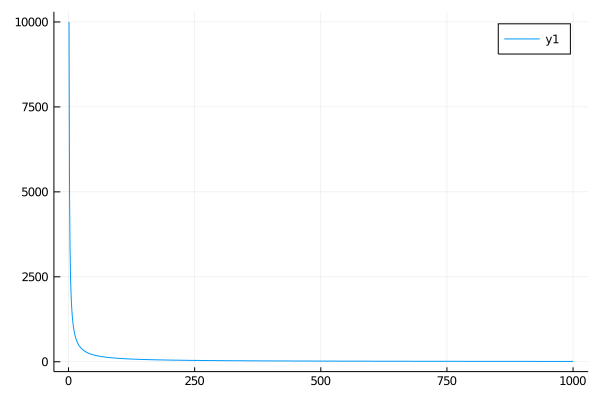

In [43]:
plot(lr_plot)

In [49]:
lr(1e-10, 1000)

9.999999499500005e6

In [51]:
f(p) = log(1 - p) - log(p)
ps = [f(p) for p = 0.01:0.01:0.9]

90-element Array{Float64,1}:
  4.59511985013459
  3.8918202981106265
  3.4760986898352733
  3.1780538303479453
  2.9444389791664403
  2.751535313041949
  2.5866893440979424
  2.4423470353692047
  2.313634929180631
  2.197224577336219
  2.090741096933769
  1.992430164690206
  1.900958761193047
  ⋮
 -1.3249254147435987
 -1.3862943611198908
 -1.4500101755059986
 -1.5163474893680882
 -1.5856272637403814
 -1.6582280766035322
 -1.7346010553881062
 -1.8152899666382492
 -1.900958761193047
 -1.992430164690206
 -2.0907410969337694
 -2.1972245773362196

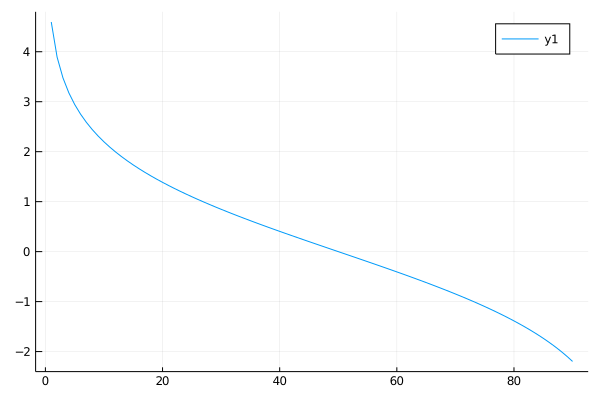

In [52]:
plot(ps)